In [1]:
import tensorflow as tf
from typing import Tuple, Optional, List, Union, Iterator

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import glob

import sys

from scipy.ndimage.filters import gaussian_filter
import time
from tensorflow.keras.layers import InputLayer, Conv2D, Concatenate, Lambda, Subtract, Add,Dense
import tensorflow_addons as tfa
import scipy.stats as st

In [2]:
def mnist_train_test(number=2):
    (x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
    x_train = x_train[..., np.newaxis]
    train_index = y_train == number
    train = x_train[train_index]
    return tf.cast(tf.convert_to_tensor(train), tf.float32)

In [3]:
def dataloader(train,bs=32):
    n = train.shape[0]
    i = 0
    while True:
        xtrain = train[i:i+bs,...]
        ytrain = train[i+1:i+bs+1,...]
        yield xtrain, ytrain
        temp=i+2*bs
        if temp>=n:
            i = temp%n
        else:
            i = i+bs

In [4]:
train =  mnist_train_test()
Dataloader = dataloader(train)                         

In [5]:
x,y=next(Dataloader)

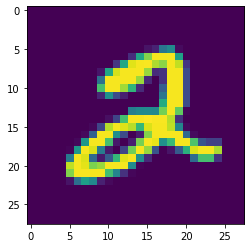

In [6]:
_ = plt.imshow(x[0])

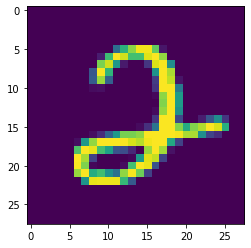

In [7]:
_ = plt.imshow(y[0])

In [8]:
(x_train, x_label), (_, _) = tf.keras.datasets.mnist.load_data()

In [9]:
def cl_dataloader(train,label,bs=32):
    n = train.shape[0]
    i = 0
    while True:
        xtrain = train[i:i+bs,...,np.newaxis]
        xlabel = label[i:i+bs]
        yield tf.cast(xtrain,tf.float32), xlabel
        i=(i+bs)%n

In [10]:
class classifier(tf.keras.models.Model):
    def __init__(self,
                 batch_size,
                 input_shape,kernel_size = 5):
        super(classifier,self).__init__()
        self.inputs = InputLayer(input_shape=input_shape, batch_size=batch_size, dtype=tf.int32)
        self.conv1 = Conv2D(filters=4, kernel_size=kernel_size, strides=1, padding="valid",
                            data_format="channels_last", use_bias=True, dilation_rate=1,  
                            activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer=None)
        self.conv2 = Conv2D(filters=8, kernel_size=kernel_size, strides=1, padding="valid",
                              data_format="channels_last", use_bias=True, dilation_rate=1,
                              activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer=None)
        self.conv3 = Conv2D(1, kernel_size=kernel_size, activation='relu')
        self.den = Dense(10, activation="relu",
                                         kernel_initializer='glorot_uniform',
                                        bias_initializer='zeros')
    @tf.function
    def call(self, inputs):
        x = self.inputs(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)  
        x = self.den(tf.reshape(x,(inputs.shape[0],-1)))
        return x

In [11]:
class clnet(): 
    def __init__(self,input_shape):  # (batch size, width, height, channels)
        self.input_shape = input_shape
        self.clf = classifier(batch_size=self.input_shape[0],
                                             input_shape=self.input_shape[1:4])
    def train(self,batch_generator,epochs=1000,learning_rate = 1e-3): 
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                             beta_1=0.9,
                                             beta_2=0.999,
                                             epsilon=1e-8)
        for epoch in range(epochs):        
            image, label = next(batch_generator)
            with tf.GradientTape() as tape:
                logits = self.clf(image)
                cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.2)
                loss = cce(tf.one_hot(label, 10 ,on_value=1, off_value=0),logits)               
                actor_grads = tape.gradient(loss, self.clf.trainable_variables)
            optimizer.apply_gradients(zip(actor_grads, self.clf.trainable_variables))
            if epoch%500==0:
                predict = tf.math.argmax(logits,axis = 1)
                print("epoch: ", epoch, "mse: ",loss.numpy(),"pred: ", predict[0].numpy())
                plt.imshow(image[0,:,:,0],cmap='gray')
                plt.show()
    def get_prob(self,images,numbers=2):
        logits = self.clf(images)
        prob = tf.nn.softmax(logits,axis=1)
        return prob[:,numbers]

In [12]:
bs = 256
cldataloader= cl_dataloader(x_train, x_label,bs = bs)
clmodel = clnet((bs,28,28,1))

clmodel.train(cldataloader,epochs=5000)

clmodel.clf.save_weights('./cl')

In [13]:
clmodel.clf.load_weights('./cl')

In [14]:
def gkern(kernlen=[21,21], nsig=[3, 3]):
    """Returns a 2D Gaussian kernel array."""

    assert len(nsig) == 2
    assert len(kernlen) == 2
    kern1d = []
    for i in range(2):
        interval = (2*nsig[i]+1.)/(kernlen[i])
        x = np.linspace(-nsig[i]-interval/2., nsig[i]+interval/2., kernlen[i]+1)
        kern1d.append(np.diff(st.norm.cdf(x)))

    kernel_raw = np.sqrt(np.outer(kern1d[0], kern1d[1]))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [15]:
class Extractor(tf.keras.models.Model):

    def __init__(self,
                 batch_size,
                 input_shape,kernel_size = 3):
        super(Extractor,self).__init__()
        self.inputs = InputLayer(input_shape=input_shape, batch_size=batch_size, dtype=tf.int32)
        self.target_inputs =  InputLayer(input_shape=input_shape,
                                         batch_size=batch_size, dtype=tf.int32)  
        self.conv1 = Conv2D(filters=16, kernel_size=kernel_size, strides=1, padding="same",
                            data_format="channels_last", use_bias=True, dilation_rate=1,  
                            activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer=None)

        self.diconv2 = Conv2D(filters=32, kernel_size=kernel_size, strides=1, padding="same",
                              data_format="channels_last", use_bias=True, dilation_rate=1,
                              activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer=None)

        self.conv_redir = Conv2D(16, (1,1), activation='relu')
        self.conv_merged = Conv2D(2, (kernel_size, kernel_size), padding = 'same',activation='relu')         
    def get_correlation_layer(self,conv3_pool_l,conv3_pool_r,
                              max_displacement=12,stride2=2,height_8=28,width_8=28):
        layer_list = []
        dotLayer = self.myDot()
        for i in range(-max_displacement, max_displacement+stride2,stride2):
            for j in range(-max_displacement, max_displacement+stride2,stride2):
                slice_b = self.get_padded_stride(conv3_pool_r,i,j,height_8,width_8)
                current_layer = dotLayer([conv3_pool_l,slice_b])
                layer_list.append(current_layer)
        return Lambda(lambda x: tf.concat(x, 3))(layer_list)
    def myDot(self):
        return Lambda(lambda x: tf.reduce_sum(tf.multiply(x[0],x[1]),axis=-1,keepdims=True))

    def get_padded_stride(self,b,displacement_x,displacement_y,height_8,width_8):
        slice_height = height_8 - abs(displacement_y)
        slice_width = width_8 - abs(displacement_x)
        start_y = abs(displacement_y) if displacement_y < 0 else 0
        start_x = abs(displacement_x) if displacement_x < 0 else 0
        top_pad    = displacement_y if (displacement_y>0) else 0
        bottom_pad = start_y
        left_pad   = displacement_x if (displacement_x>0) else 0
        right_pad  = start_x

        gather_layer = Lambda(lambda x: tf.pad(tf.slice(x,begin=[0,start_y,start_x,0],size=[-1,slice_height,slice_width,-1]),
                                               paddings=[[0,0],[top_pad,bottom_pad],[left_pad,right_pad],[0,0]]))(b)
        return gather_layer    
    @tf.function
    def call(self, inputs,inputs_target):

        x = self.inputs(inputs)
        x_target = self.inputs(inputs_target)
        x = self.conv1(x)
        x_target = self.conv1(x_target)
        x = self.diconv2(x)
        x_target = self.diconv2(x_target)  

        corr_layer = self.get_correlation_layer(x_target, x)
        conv_redir = self.conv_redir(x_target)
        conv_with_corr = Concatenate()([conv_redir,corr_layer])
        conv_merged = self.conv_merged(conv_with_corr) 
        moving = tf.image.convert_image_dtype(inputs, tf.dtypes.float32)
        moved = tfa.image.dense_image_warp(moving, conv_merged) 
        return moved,conv_merged


In [16]:
class RL(tf.keras.models.Model):

    def __init__(self,
                 batch_size,
                 input_shape,kernel_size = 3):
        super(RL,self).__init__()
        self.inputs = InputLayer(input_shape=(28,28,2), batch_size=batch_size, dtype=tf.int32)
        self.actor_diconv5 = Conv2D(filters=8, kernel_size=3, strides=1, padding="same",
                              data_format="channels_last", use_bias=True, dilation_rate=1,
                              activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer=None)
            
        self.actor_conv6 = Conv2D(filters=5,  # number of actions
                                  kernel_size=3, strides=1, padding="same",
                                  data_format="channels_last", use_bias=True, dilation_rate=1,
                                  activation="softmax", kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer=None)
        self.critic_diconv5 = Conv2D(filters=8, kernel_size=3, strides=1, padding="same",
                                     data_format="channels_last", use_bias=True, dilation_rate=1,
                                     activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer=None)
        self.critic_conv6 = Conv2D(filters=1, kernel_size=3, strides=1, padding="same",
                                   data_format="channels_last", use_bias=True, dilation_rate=1,
                                   activation="linear", kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer=None)
         
    @tf.function
    def call(self, inputs):
        conv_merged = self.inputs(inputs)
        actor = self.actor_diconv5(conv_merged)
        actor = self.actor_conv6(actor) 
        critic = self.critic_diconv5(conv_merged) 
        critic = self.critic_conv6(critic)
        return actor,critic

In [ ]:
class PixelwiseA3CNetwork:
    def kernel_init(self, shape, dtype=tf.float32, partition_info=None):
        kernel = np.zeros(shape)
        kernel[:,:,0,0] = gkern([shape[0], shape[1]])
        return kernel 
    def __init__(self,input_shape):  # (batch size, width, height, channels)
        self.input_shape = input_shape
        self.FE = Extractor(batch_size=self.input_shape[0],
                                             input_shape=self.input_shape[1:4])
        self.AC = RL(batch_size=self.input_shape[0],
                                             input_shape=(28,28,2))
        self.convR = Conv2D(filters=1, kernel_size=3, strides=1, padding="same",
                                   data_format="channels_last", use_bias=False, 
                            dilation_rate=1, kernel_initializer=self.kernel_init)
    def FEtrain(self,batch_generator,epochs=1000,learning_rate = 3e-4): 
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                             beta_1=0.9,
                                             beta_2=0.999,
                                             epsilon=1e-8)
        for epoch in range(epochs):        
            moving, fixed = next(batch_generator)
            with tf.GradientTape() as tape:
                moved,flow = self.FE(moving, fixed)
                sim_loss = tf.reduce_mean(tf.square(moved-fixed))
                size_loss = abs(tf.reduce_mean(tf.square(moved)-tf.square(moving)))
                smooth_loss1 = tf.reduce_mean(tf.square(flow[:,:27,:27,:]-flow[:,1:,1:,:])**4)
                smooth_loss5 = tf.reduce_mean(tf.square(flow[:,:26,:26,:]-flow[:,2:,2:,:])**2)
                smooth_loss2 = tf.reduce_mean(tf.square(flow[:,1:,:27,:]-flow[:,:27,1:,:])**4)
                smooth_loss6 = tf.reduce_mean(tf.square(flow[:,2:,:26,:]-flow[:,:26,2:,:])**2)
                smooth_loss3 = tf.reduce_mean(tf.square(flow[:,1:,:,:]-flow[:,:27,:,:])**4)
                smooth_loss7 = tf.reduce_mean(tf.square(flow[:,2:,:,:]-flow[:,:26,:,:])**2)
                smooth_loss4 = tf.reduce_mean(tf.square(flow[:,:,:27,:]-flow[:,:,1:,:])**4)
                smooth_loss8 = tf.reduce_mean(tf.square(flow[:,:,:26,:]-flow[:,:,2:,:])**2)
                smooth_loss= smooth_loss2+smooth_loss2+smooth_loss3+smooth_loss4+smooth_loss5+smooth_loss6+smooth_loss7+smooth_loss8
                total_loss = sim_loss+0.3*smooth_loss+2*size_loss
                actor_grads = tape.gradient(total_loss, self.FE.trainable_variables)
            optimizer.apply_gradients(zip(actor_grads, self.FE.trainable_variables))
            if epoch%100==0:
                print("epoch: ", epoch, "mse: ",total_loss.numpy())
                print("sim_loss: ", sim_loss.numpy(), 
                      "size_loss: ",size_loss.numpy(),
                      "smooth_loss: ",smooth_loss.numpy())
    def RLtrain(self,batch_generator,epochs=1000,learning_rate = 1e-3,traj_len = 101,gamma = 0.9): 
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                             beta_1=0.9,
                                             beta_2=0.999,
                                             epsilon=1e-8)
        for epoch in range(epochs):        
            moving, fixed = next(batch_generator)
            with tf.GradientTape() as tape:
                o_moving = tf.identity(moving)
                _,tm0_t0 = self.FE(moving, fixed)
                m0_t0 =tf.zeros(shape=(moving.shape[0], moving.shape[1], moving.shape[2], 2),dtype=tf.float32)
                r = {}
                V = {}
                past_action_log_prob = {}
                past_action_entropy = {}
                for t in range(traj_len):
                    diff = tm0_t0 - m0_t0
                    actor,critic = self.AC(diff)
                    a_t = tf.clip_by_value(actor, 1e-6, 1)
                    sampled_a_t = self._sample_tf(a_t)                
                    past_action_log_prob[t] = self._mylog_prob(tf.math.log(a_t), sampled_a_t)
                    past_action_entropy[t] = self._myentropy(a_t, tf.math.log(a_t))
                    V[t] = critic
                    moved,m0_t1 = self.update(o_moving, m0_t0,sampled_a_t)               
                    sim_reward = tf.reduce_mean(tf.square(diff)-tf.square(tm0_t0-m0_t1),axis=3)
                    prob=tf.reduce_mean(clmodel.get_prob(moved,2)).numpy()
                    if prob<0.6:
                        sim_reward-=5
                    close = tf.reduce_mean(tf.square(moved-fixed)).numpy()
                    if close <5e3:
                        sim_reward+=5
                    smooth_penalty = tf.cast(self.smooth(m0_t1),dtype=tf.float32)
                    move_penalty = tf.reduce_sum(tf.abs(m0_t1),axis=3)
                    r_t = 100*sim_reward-1e-3*move_penalty-1e-1*smooth_penalty
                    r[t] = tf.cast(r_t[...,np.newaxis]/255/255, dtype=tf.float32)
                    if epoch%100==0 and t%(6)==0:
                        print('sim_reward',tf.reduce_mean(sim_reward).numpy(),
                              'prob: ',prob,
                              'close: ', close,
                              'smooth_penalty',tf.reduce_mean(smooth_penalty).numpy(),
                            'move_penalty',tf.reduce_sum(move_penalty).numpy())
                        plt.subplot(1,3,1)
                        plt.imshow(moving[0,:,:,0],cmap='gray')
                        plt.title('moving:')
                        plt.subplot(1,3,2)
                        plt.imshow(moved[0,:,:,0],cmap='gray')
                        plt.title('moved:')
                        plt.subplot(1,3,3)
                        plt.imshow(fixed[0,:,:,0],cmap='gray')
                        plt.title('fixed:')
                        plt.show() 
                    moving = moved
                    m0_t0 = m0_t1
                    if prob<0.4:
                        moving, fixed = next(batch_generator)
                        o_moving = tf.identity(moving)
                        _,tm0_t0 = self.FE(moving, fixed)
                        m0_t0 =tf.zeros(shape=(moving.shape[0], moving.shape[1], moving.shape[2], 2),dtype=tf.float32)
                actor_loss = 0
                critic_loss = 0
                for t in reversed(range(traj_len-1)):
                    A = r[t]+gamma*self.conv_R(V[t+1])-V[t]
                    log_prob = past_action_log_prob[t]
                    entropy = past_action_entropy[t]
                    actor_loss -= (log_prob * A+0* entropy)
                    critic_loss += A ** 2
                total_loss= tf.reduce_mean(actor_loss+critic_loss)
                actor_grads = tape.gradient(total_loss, self.AC.trainable_variables)
            optimizer.apply_gradients(zip(actor_grads, self.AC.trainable_variables))
            if epoch%100==0:
                print("epoch: ", epoch, "total_loss: ",total_loss.numpy(),
                     'actor_loss',tf.reduce_mean(actor_loss).numpy(),
                     'critic_loss',tf.reduce_mean(critic_loss).numpy())
                
    def FEpredict(self,batch_generator,epochs=100):       
        
        for epoch in range(epochs):        
            moving, fixed = next(batch_generator)
            Loss=[]
            moved,flow = self.FE(moving, fixed)
            total_loss = tf.reduce_mean(tf.square(moved-fixed))
            Loss.append(total_loss)
            grid = np.zeros(moving.shape)
            for i in range(28):
                for j in range(28):
                    if i%5==0 or j%5==0:
                        grid[:,i,j,:]=255
            wgrid = tfa.image.dense_image_warp(grid, flow) 
            if (epoch%10)==0:
                plt.subplot(1,4,1)
                plt.imshow(moving[0,:,:,0],cmap='gray')
                plt.title('moving:')
                plt.subplot(1,4,2)
                plt.imshow(moved[0,:,:,0],cmap='gray')
                plt.title('moved:')
                plt.subplot(1,4,3)
                plt.imshow(fixed[0,:,:,0],cmap='gray')
                plt.title('fixed:')
                plt.subplot(1,4,4)
                plt.imshow(wgrid[0,:,:,0],cmap='gray')
                plt.title('grid:')
                plt.show()    
        print(np.mean(Loss))
        
    def RLpredict(self,batch_generator,epochs=300,gamma = 0.99):
        RS=[]
        for epoch in range(epochs):        
            moving, fixed = next(batch_generator)
            o_moving = tf.identity(moving)
            _,m0_t0 = self.FE(moving, fixed)
            R=[]
            for t in range(31):                
                actor,critic = self.AC(m0_t0)
                
                a_t = tf.clip_by_value(actor, 1e-6, 1)
                sampled_a_t = self._sample_tf(a_t)
                
                moved,m0_t1 = self.update(moving, m0_t0,sampled_a_t)  
                
                sim_reward = tf.square(moving-fixed)-tf.square(moved-fixed) 
                if tf.reduce_mean(tf.square(moved-fixed)).numpy()<85:
                    sim_reward+=255
                size_reward = -tf.cast(tf.abs(tf.square(moved)-tf.square(o_moving)),dtype=tf.float32)      
                smooth_reward = -tf.cast(self.smooth(m0_t1),dtype=tf.float32)  
                r_t = tf.reduce_mean(sim_reward+0.03*smooth_reward[...,np.newaxis]+size_reward)
                R.append(r_t)
                moving = moved
                if epoch%100==0 and t%6==0:
                    plt.subplot(3,6,t//6+1+6*epoch//100)
                    plt.imshow(moving[0,:,:,0])
                    plt.title(t//6+1) 
                    plt.show()
            reward=0
            for r in reversed(R):
                reward*=gamma
                reward+=r
            RS.append(reward) 
        print(np.mean(RS))
        
    @staticmethod
    @tf.function
    def _mse(a, b, c):
        """
        Calculates the mean squared error for image batches given by the formula:
        mse = (a-b)**2 - (a-c)**2
        
        shape=(s_t0.shape[0], s_t0.shape[2], s_t0.shape[1], 3)
        
        :param a:
        :param b:
        :param c:
        :return:
        """
        a = tf.cast(a, tf.float32)
        b = tf.cast(b, tf.float32)
        c = tf.cast(c, tf.float32)
        
        mse = tf.math.reduce_euclidean_norm(a-b, axis=[3])
        mse -= tf.math.reduce_euclidean_norm(a-c, axis=[3])

        return mse 

    @staticmethod
    @tf.function
    def _myentropy(prob, log_prob):
        return tf.stack([- tf.math.reduce_sum(prob * log_prob, axis=-1)], axis=-1)

    @staticmethod
    @tf.function
    def _mylog_prob(data, indexes):
        """
        Selects elements from a multidimensional array.
        :param data: image_batch
        :param indexes: indices to select
        :return: the selected indices from data eg.: data=[[11, 2], [3, 4]] indexes=[0,1] --> [11, 4]
        """
        n_actions = data.shape[3]
        one_hot_mask = tf.one_hot(indexes, n_actions,
                                  on_value=True, off_value=False, dtype=tf.bool)
        output = tf.boolean_mask(data, one_hot_mask)
        return tf.reshape(output,indexes.shape+[1])

    @staticmethod
    @tf.function
    def _sample_tf(distribution):
        """
        Samples the image action distribution returned by the last softmax activation.
        :param distribution: output of a softmax activated layer, an array with probability distributions,
        usually shaped (batch_size, channels, widht, height, number_of_actions) NCHW!
        :return: array shaped of (batch_size, channels, widht, height)
        """
        d = tf.reshape(distribution, (-1, distribution.shape[-1]))
        d = tf.math.log(d)
        d = tf.random.categorical(d, num_samples=1)
        d = tf.reshape(d, distribution.shape[0:-1])
        return d
    @staticmethod
    @tf.function
    def update(moving, m0_t0,action):
        action1 = action[...,np.newaxis]
        action2 = action[...,np.newaxis]
        action1 = (action1%2*2+tf.sign(action1-2))*tf.cast(action1<2,dtype=tf.int64)
        action2 = (-(action2%2*2)+tf.sign(action2-2))*tf.cast(action2>2,dtype=tf.int64)
        addon = Concatenate(axis=3)([action1,action2])
        addon = tf.cast(addon,dtype=tf.float32)
        m0_t1 = m0_t0+addon
        moved = tfa.image.dense_image_warp(moving, m0_t1) 
        return moved,m0_t1
    @tf.function
    def conv_R(self,reward):
        return self.convR(reward)
    def smooth(self,m0):
        s1 = tf.square(m0[:,:27,:,:]-m0[:,1:,:,:])
        s2 = tf.square(m0[:,:,:27,:]-m0[:,:,1:,:])
        s11 = tf.zeros((m0.shape[0],1,28,2))
        s22 = tf.zeros((m0.shape[0],28,1,2))
        smooth = Concatenate(axis=1)([s1,s11])+Concatenate(axis=2)([s2,s22])
        return tf.cast(tf.reduce_sum(smooth,axis=3)/2 ,dtype= tf.int32)

bs=128
ks = 3
train =  mnist_train_test()
Dataloader = dataloader(train,bs) 
model = PixelwiseA3CNetwork(input_shape=(bs, 28, 28, 1))
model.FE.load_weights('./FE4')

model.FEtrain(Dataloader, epochs=10000)

In [30]:
model.FE.save_weights('./FE4')

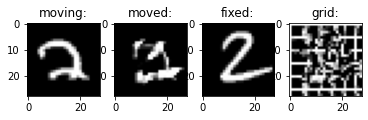

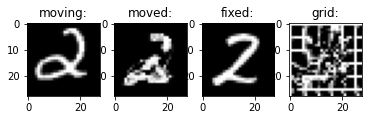

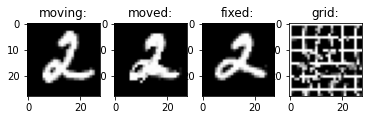

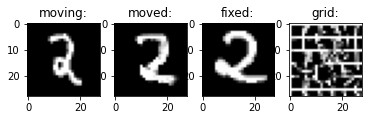

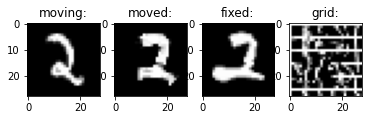

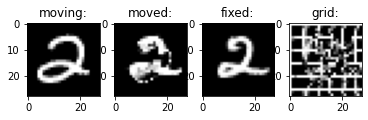

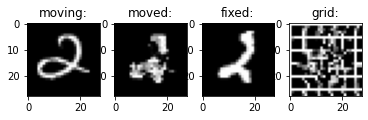

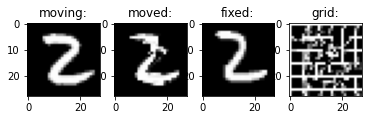

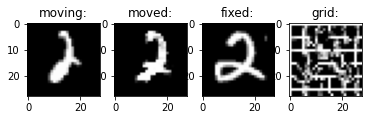

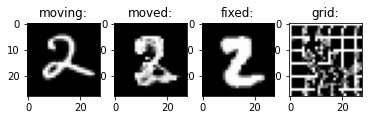

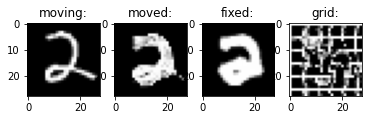

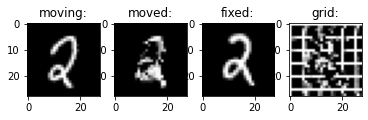

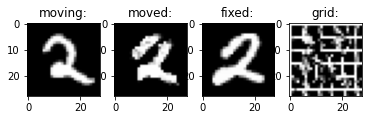

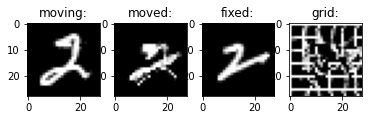

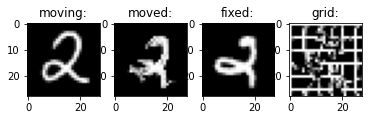

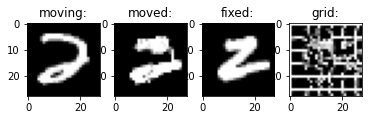

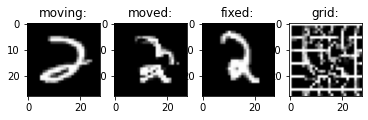

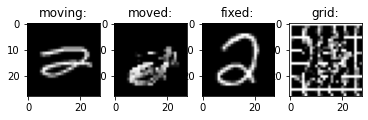

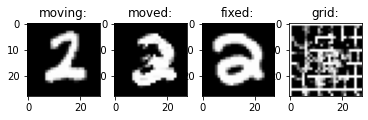

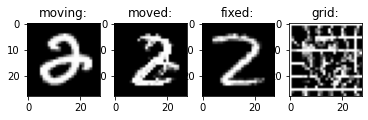

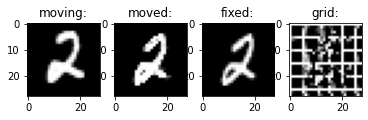

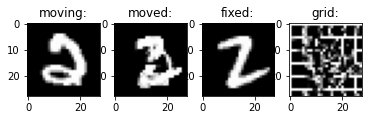

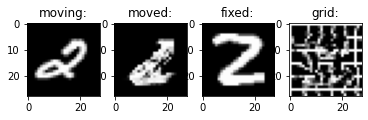

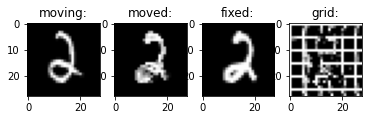

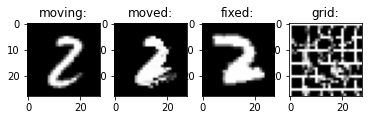

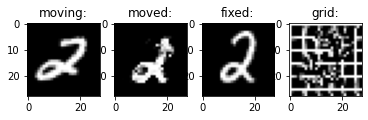

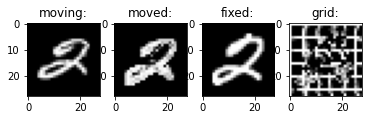

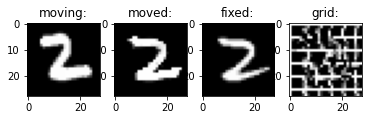

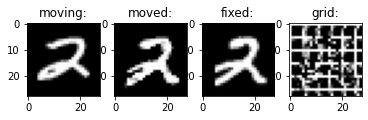

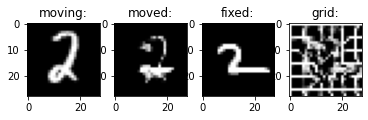

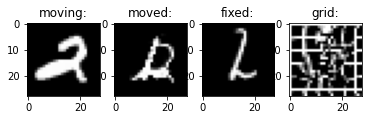

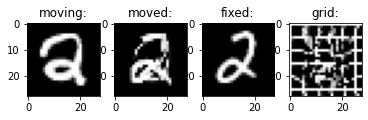

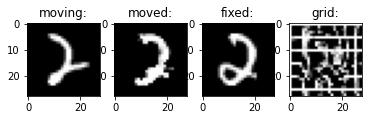

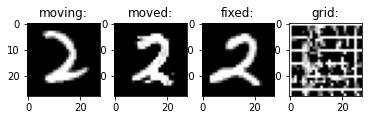

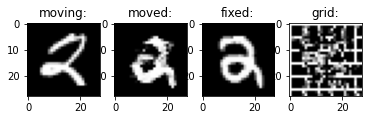

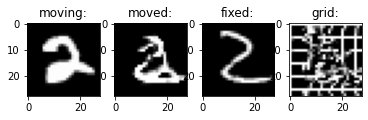

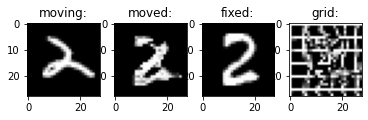

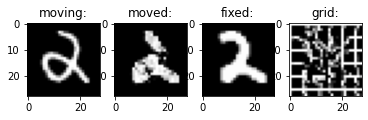

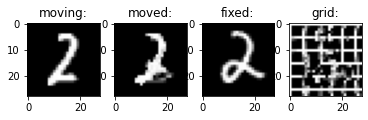

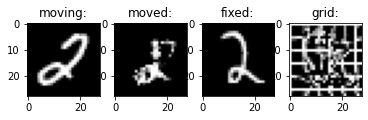

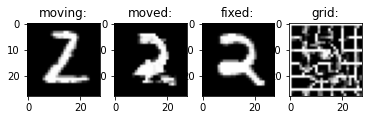

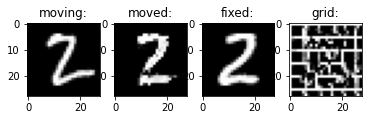

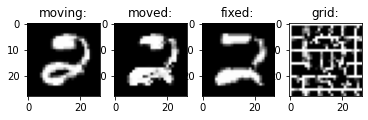

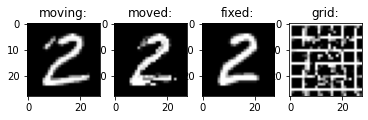

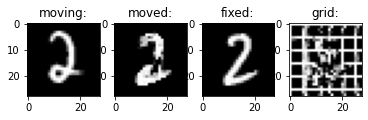

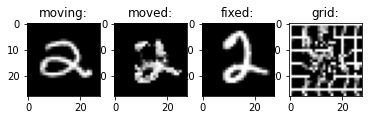

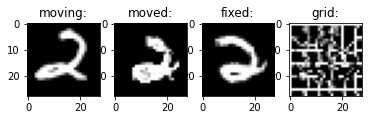

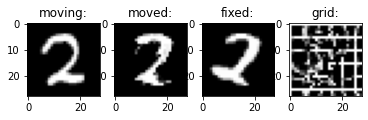

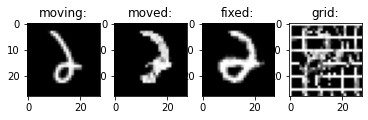

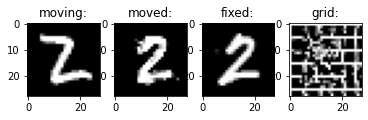

2858.6033


In [31]:
model.FE.load_weights('./FE4')
model.FEpredict(Dataloader,epochs=500)

In [ ]:
model.FE.load_weights('./FE4')

In [ ]:
bs=32
Dataloader = dataloader(train,bs) 
model = PixelwiseA3CNetwork(input_shape=(bs, 28, 28, 1))
model.FE.load_weights('./FE')
model.FE.load_weights('./AC')

In [ ]:
model.RLtrain(Dataloader, epochs=15000)

In [ ]:
model.RLpredict(Dataloader, epochs=300)

In [ ]:
model.AC.save_weights('./AC')

In [ ]:
moving, fixed = next(Dataloader)
_,tm0_t0 = model.FE(moving, fixed)

In [ ]:
m0_t0 =tf.zeros(shape=(moving.shape[0], moving.shape[1], moving.shape[2], 2),dtype=tf.float32)
actor,critic = model.AC(tm0_t0-m0_t0)
a_t = tf.clip_by_value(actor, 1e-6, 1)
sampled_a_t = model._sample_tf(a_t) 
grid = np.zeros(moving.shape)
for i in range(28):
    for j in range(28):
        if i%7==0 or j%7==0:
            grid[:,i,j,:]=255
wgrid,m0_t1  = model.update(grid, m0_t0,sampled_a_t)
plt.imshow(wgrid[0,...,0])
plt.show()

In [ ]:
plt.imshow(moving[0,...,0])
plt.show()

In [ ]:
plt.imshow(fixed[0,...,0])
plt.show()

In [ ]:
moved,m0_t1  = model.update(moving, m0_t0,sampled_a_t)
plt.imshow(moving[0,...,0])
plt.show()